# Feature Selection

Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested.

Having too many irrelevant features in your data can decrease the accuracy of the models. Three benefits of performing feature selection before modeling your data are:

* Reduces Overfitting
* Improves Accuracy
* Reduces Training

In [37]:
# Imports

import glob
import string
import ast

# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier, export_graphviz 
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


#metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics import precision_recall_fscore_support, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

### Importing CSV files

In [17]:
train = pd.DataFrame()
for f in glob.glob('./Preprocessed/Train.csv'):
    df = pd.read_csv(f)
    train = train.append(df,ignore_index=True)        

In [18]:
test = pd.DataFrame()
for f in glob.glob('./Preprocessed/Test.csv'):
    df = pd.read_csv(f)
    test = test.append(df,ignore_index=True)  

In [19]:
validSet = pd.DataFrame()
for f in glob.glob('./Preprocessed/Validation.csv'):
    df = pd.read_csv(f)
    validSet = validSet.append(df,ignore_index=True) 

In [5]:
train.shape, validSet.shape, test.shape

((2230, 37), (558, 37), (575, 37))

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2230 entries, 0 to 2229
Data columns (total 37 columns):
id                       2230 non-null object
followers_count          2230 non-null int64
friends_count            2230 non-null int64
listedcount              2230 non-null int64
favourites_count         2230 non-null int64
verified                 2230 non-null int64
statuses_count           2230 non-null int64
default_profile          2230 non-null int64
default_profile_image    2230 non-null int64
has_extended_profile     2230 non-null int64
name                     2230 non-null object
bot                      2230 non-null int64
In_reply                 2230 non-null float64
retweet_count            2230 non-null float64
fav_count                2230 non-null float64
total_usrmention         2230 non-null float64
days_std                 2230 non-null float64
hours_std                2230 non-null float64
modified_hour            2230 non-null int64
acc_age                 

In [7]:
xset = train
X_all = xset.drop(['id','bot','name'], axis=1)
y_all = xset['bot']

###  Recursive Feature Elimination
The Recursive Feature Elimination (RFE) method is a feature selection approach. It works by recursively removing attributes and building a model on those attributes that remain.

Optimal number of features : 24


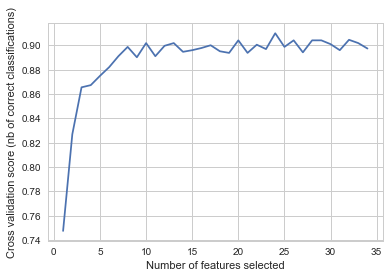

In [9]:
# Create the RFE object and compute a cross-validated score.
model = ExtraTreesClassifier()
rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(10),scoring='accuracy')
rfecv.fit(X_all, y_all)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
model2 = ExtraTreesClassifier()
model2.fit(X_all, y_all)

#Add features and their importances to a dictionary
feature_imp_dict = dict(zip(X_all.columns.values, model2.feature_importances_))

for x in sorted(zip(model2.feature_importances_,list(X_all)))[::-1]:
    print x

(0.17373115925646712, 'acc_age')
(0.067475819731959333, 'verified')
(0.06200391945104098, 'descbot')
(0.059738667466549634, 'avg_fav_count')
(0.044453114224096216, 'hours_std')
(0.04237151191125875, 'avg_In_reply')
(0.042017273992923036, 'default_profile')
(0.041951052243900853, 'In_reply')
(0.039054402223271403, 'retweet_count')
(0.038101145785870275, 'avg_total_usrmention')
(0.032239590920496379, 'total_usrmention')
(0.028684251491314171, 'avg_retweet_count')
(0.027366641596371442, 'fav_count')
(0.026883580332758384, 'screennamebot')
(0.020905042949952244, 'tweets_per_day')
(0.019128739936916002, 'days_std')
(0.018512631361533728, 'desc_length')
(0.018434657266219782, 'has_extended_profile')
(0.016480063914361544, 'statuses_count')
(0.015858571486091828, 'sn_length')
(0.0151683613132504, 'listedcount')
(0.014906408843491892, 'friends_count')
(0.014503347780671427, 'ff_ratio')
(0.014094336538101659, 'favourites_count')
(0.013756586152669675, 'followers_count')
(0.013720750298286011, '

In [10]:
#define a function to print ROC curves. 
#It should take in only arrays/lists of predictions and outcomes
from sklearn.metrics import roc_curve, auc

def plotUnivariateROC(preds, truth, label_string):
    '''
    preds is an nx1 array of predictions
    truth is an nx1 array of truth labels
    label_string is text to go into the plotting label
    '''
    #Student input code here
    #1. call the roc_curve function to get the ROC X and Y values
    fpr, tpr, thresholds = roc_curve(truth, preds)
    #2. Input fpr and tpr into the auc function to get the AUC
    roc_auc = auc(fpr, tpr)
    
    #we are doing this as a special case because we are sending unfitted predictions
    #into the function
    if roc_auc < 0.5:
        fpr, tpr, thresholds = roc_curve(truth, -1 * preds)
        roc_auc = auc(fpr, tpr)

    #chooses a random color for plotting
    c = (np.random.rand(), np.random.rand(), np.random.rand())

    #create a plot and set some options
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc

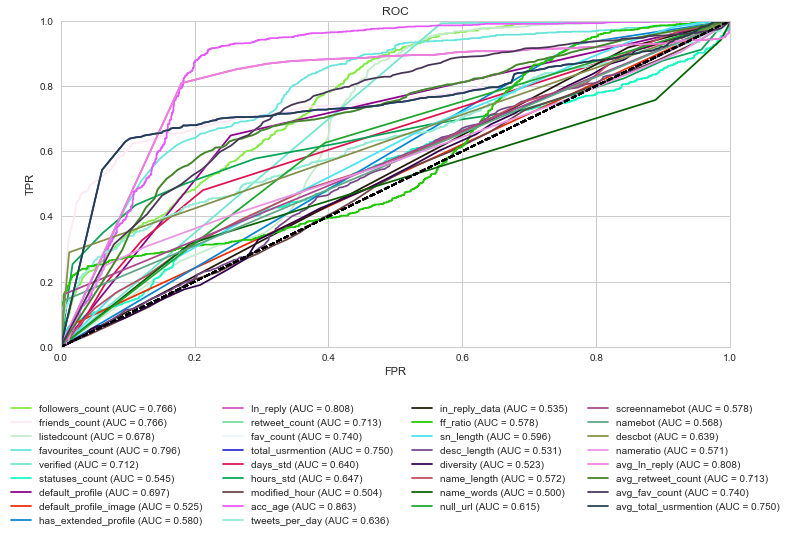

In [11]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

#Plot the univariate AUC on the training data. Store the AUC

#Student put code here
feature_auc_dict = {}
for col in X_all.columns:
    feature_auc_dict[col] = plotUnivariateROC(X_all[col], y_all, col)


# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 4, prop = {'size':10})

In [12]:
#Add auc and mi each to a single dataframe
df_auc = pd.DataFrame(pd.Series(feature_auc_dict), columns = ['auc'])
df_imp = pd.DataFrame(pd.Series(feature_imp_dict), columns = ['imp'])

#Now merge the two on the feature name
feat_imp_df = df_auc.merge(df_imp, left_index = True, right_index = True)
feat_imp_df

,auc,imp
In_reply,0.808118,0.041951
acc_age,0.863103,0.173731
avg_In_reply,0.808118,0.042372
avg_fav_count,0.740165,0.059739
avg_retweet_count,0.712838,0.028684
avg_total_usrmention,0.750168,0.038101
days_std,0.639510,0.019129
default_profile,0.697107,0.042017
default_profile_image,0.525217,0.005325
desc_length,0.531191,0.018513


### To put the different metrics on the same scale, we'll use pandas rank() method for each feature.

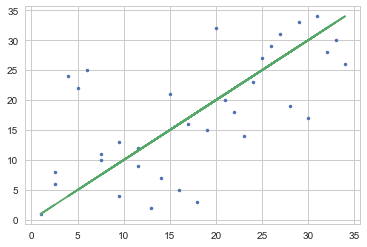

In [13]:
#Now create a df that holds the ranks of auc and mi 
feat_ranks = feat_imp_df.rank(axis = 0, ascending = False)

#Plot the two ranks
plt.plot(feat_ranks.auc, feat_ranks.imp, '.')
#Plot a y=x reference line
plt.plot(feat_ranks.auc, feat_ranks.auc,)

In [14]:
#Now create lists of top 10 features for both auc and mi
top5_auc = list(feat_ranks[(feat_ranks.auc <= 26)].index.values)
top5_imp = list(feat_ranks[(feat_ranks.imp <= 26)].index.values)
for x in zip(top5_auc, top5_imp):
    print x

('In_reply', 'In_reply')
('acc_age', 'acc_age')
('avg_In_reply', 'avg_In_reply')
('avg_fav_count', 'avg_fav_count')
('avg_retweet_count', 'avg_retweet_count')
('avg_total_usrmention', 'avg_total_usrmention')
('days_std', 'days_std')
('default_profile', 'default_profile')
('descbot', 'desc_length')
('fav_count', 'descbot')
('favourites_count', 'fav_count')
('ff_ratio', 'favourites_count')
('followers_count', 'ff_ratio')
('friends_count', 'followers_count')
('has_extended_profile', 'friends_count')
('hours_std', 'has_extended_profile')
('listedcount', 'hours_std')
('name_length', 'listedcount')
('nameratio', 'name_words')
('null_url', 'retweet_count')
('retweet_count', 'screennamebot')
('screennamebot', 'sn_length')
('sn_length', 'statuses_count')
('total_usrmention', 'total_usrmention')
('tweets_per_day', 'tweets_per_day')
('verified', 'verified')


The next step is the conclusive step from all the analysis done above. We want to test which method above can be used to produce the best subset of features. What we'll do is use the top 5 features ranked by both AUC and the decision tree feature importance and compare them against each other with different algorithms.

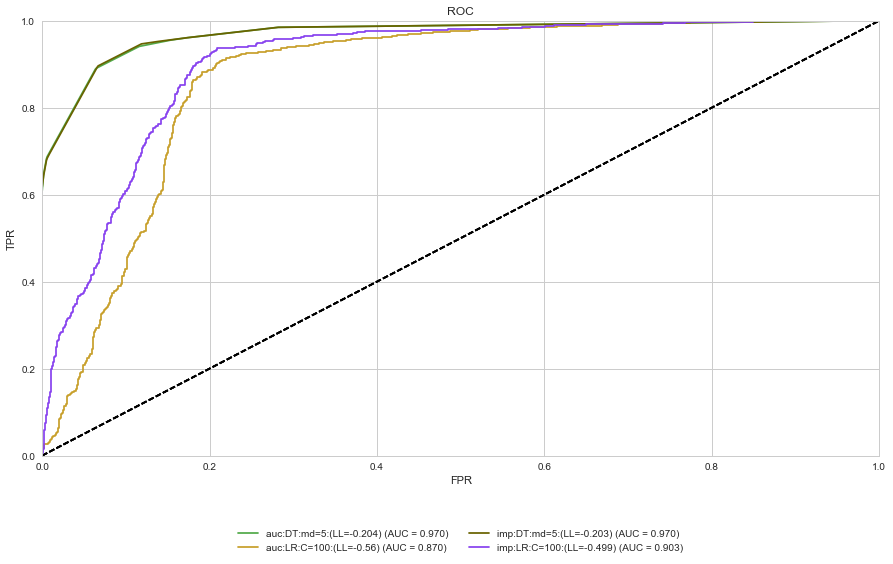

In [15]:
'''
Now do the following
1. Split the data into 80/20 train/test
2. For each set of features:
- build two decision trees (max_depth in {10, 20}) 
- build two logistic regression (C in {10**-2, 10**2})
- get the auc and log-loss on the test set
'''


def getLogLoss(Ps, Ys, eps = 10**-6):
    return ((Ys == 1) * np.log(Ps + eps) + (Ys == 0) * np.log(1 - Ps + eps)).mean()

#Split into train and test randomly without using sklearn package
#Note, there are many ways to do this:

train_pct = 0.8
#1. create an array of n random uniform variables drawn on [0,1] range
rand = np.random.rand(X_all.shape[0])
#2. Convert to boolean where True = random number < train_pct
rand_filt = (rand < train_pct)

#Use the filter to index data

train = X_all[rand_filt]
test = X_all[(rand_filt == False)]


fsets = [top5_auc, top5_imp]
fset_descr = ['auc', 'imp']
mxdepths = [5]
Cs = [10**2]


#Set up plotting box
fig = plt.figure(figsize = (15, 8))
ax = plt.subplot(111)


for i, fset in enumerate(fsets):
    descr = fset_descr[i]
    #set training and testing data
    Y_train = y_all
    X_train = X_all[fset]
    Y_test = y_all
    X_test = X_all[fset]
    
    for d in mxdepths:
        dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = d)
        dt.fit(X_train, Y_train)
        preds_dt = dt.predict_proba(X_test)[:, 1]
        ll_dt = getLogLoss(preds_dt, Y_test)
        
        plotUnivariateROC(preds_dt, Y_test, '{}:DT:md={}:(LL={})'.format(descr, d, round(ll_dt, 3)))

        
    for C in Cs:
        lr = LogisticRegression(C = C)
        lr.fit(X_train, Y_train)
        preds_lr = lr.predict_proba(X_test)[:, 1]
        ll_lr = getLogLoss(preds_lr, Y_test)

        plotUnivariateROC(preds_lr, Y_test, '{}:LR:C={}:(LL={})'.format(descr, C, round(ll_lr, 3)))

    
# Put a legend below current axis
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.0 , box.width, box.height * 1])
ax.legend(loc = 'upper center', bbox_to_anchor = (0.5, -0.15), fancybox = True, 
              shadow = True, ncol = 2, prop = {'size':10})

## Final Features 

The following are the list of final features to be included.

* In_reply
* acc_age
* avg_In_reply
* avg_fav_count
* avg_retweet_count
* avg_total_usrmention
* days_std
* default_profile
* descbot
* fav_count
* favourites_count
* ff_ratio
* followers_count
* friends_count
* has_extended_profile
* hours_std
* listedcount
* name_length
* nameratio
* null_url
* retweet_count
* screennamebot
* sn_length
* total_usrmention
* tweets_per_day
* verified

In [20]:
features = list(top5_imp)
X_train = train[features]
y_train = train['bot']
X_test = validSet[features]
y_test = validSet['bot']
final_test = test[features]

In [21]:
features2 = ['acc_age','default_profile','descbot','fav_count','favourites_count','ff_ratio','followers_count',\
                   'friends_count','has_extended_profile','listedcount','name_length','nameratio','null_url',\
                   'screennamebot','sn_length','tweets_per_day','verified']
X_train2 = train[features2]
y_train2 = train['bot']
X_test2 = validSet[features2]
y_test2 = validSet['bot']
final_test2 = test[features2]

## Feature Scaling

In [24]:
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
poly_feature = PolynomialFeatures(degree=3)

X_train =  poly_feature.fit_transform(X_train)
X_test =  poly_feature.fit_transform(X_test)
final_test = poly_feature.transform(final_test)

X_train2 =  poly_feature.fit_transform(X_train2)
X_test2 =  poly_feature.fit_transform(X_test2)
final_test2 = poly_feature.transform(final_test2)

fs_m1 = StandardScaler().fit(X_train) 
fs_m2 = StandardScaler().fit(X_train2)

Xs_train = fs_m1.transform(X_train)
Xs_train2 = fs_m2.fit_transform(X_train2)


Xs_test = fs_m1.transform(X_test)
Xs_test2 = fs_m2.transform(X_test2)

sfinal_test1 = fs_m1.transform(final_test)
sfinal_test2 = fs_m2.transform(final_test2)

# Models

### Decision Tree

In [152]:
# Decision Tree

clf = DecisionTreeClassifier()

parameters = {'max_features': [10,12,14,16], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [3, 5, 6, 8, 10], 
              'min_samples_split': [10, 20, 30],
              'min_samples_leaf': [1,5,8],
              'min_impurity_split': [0.00000001, 0.0000001]
             }

acc_scorer = make_scorer(accuracy_score)

#grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(Xs_train2, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

clf.fit(Xs_train2, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=16, max_leaf_nodes=None, min_impurity_split=1e-08,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [153]:
# To view the decision Tree
export_graphviz(clf,out_file='tree.dot') 

In [159]:
predictions = clf.predict(Xs_test2)
print(accuracy_score(y_test, predictions))
print np.array(cross_val_score(clf, Xs_train2, y_train, cv=10) ).mean()
print f1_score(y_test,predictions)

0.86917562724
0.880712997992
0.865064695009


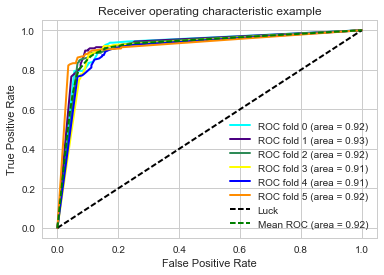

In [160]:
X = X_train.as_matrix()
y = y_train.as_matrix()
n_samples, n_features = X.shape

cv = StratifiedKFold(n_splits=6)
classifier = clf

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)

colors = cycle(['cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])
lw = 2

i = 0
for (train, test), color in zip(cv.split(X, y), colors):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=lw, color=color,
             label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= cv.get_n_splits(X, y)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression

After polynomial feature transformation, the total number features were 3654

In [35]:
Xs_train2.shape

(2230, 3654)

In [39]:
lr = LogisticRegression(n_jobs=-1,C=100000,fit_intercept=True,penalty='l2',multi_class='multinomial',solver='lbfgs')
lr_grid_search_poly = lr.fit(Xs_train2,y_train)

In [54]:
predictions = lr_grid_search_poly.predict(Xs_test2)
y = lr_grid_search_poly.predict(Xs_test2)
print (accuracy_score(y_test, predictions))
print np.array(cross_val_score(lr_grid_search_poly, Xs_train2, y_train, cv=10) ).mean()
print f1_score(y_test,predictions)

0.879928315412
0.859642716467
0.882661996497


In [57]:
print classification_report(y, y_test)

             precision    recall  f1-score   support

          0       0.87      0.88      0.88       271
          1       0.89      0.88      0.88       287

avg / total       0.88      0.88      0.88       558



### Neural Networks

After performing multiple tries, we found the parameters for the MLPClassifier. The choosen parameters are listed below,

* solver = lbfgs
* alpha = 0.001
* layer = [17,10]
* activation = tanh

In [58]:
clf_mlp = MLPClassifier(solver='lbfgs', alpha=0.001,hidden_layer_sizes=(17,10), random_state=1,
                    activation='tanh',tol=0.000001,warm_start = 'false')

clf_mlp.fit(Xs_train2, y_train)

MLPClassifier(activation='tanh', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(17, 10), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=1e-06, validation_fraction=0.1, verbose=False,
       warm_start='false')

In [59]:
predictions = clf_mlp.predict(Xs_test2)
print accuracy_score(y_test, predictions)
print np.array(cross_val_score(clf_mlp, Xs_train2, y_train, cv=10)).mean()
print f1_score(y_test, predictions)

0.856630824373
0.845306918065
0.857142857143


In [60]:
print classification_report(predictions, y_test)

             precision    recall  f1-score   support

          0       0.87      0.84      0.86       282
          1       0.85      0.87      0.86       276

avg / total       0.86      0.86      0.86       558



### RandomForest Classifier with Adaboosting (FeatureSet-1)

In [110]:
rf_clf = RandomForestClassifier()

parameters = {'n_estimators': [10,20,25], 
              'max_features': [16,21], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [6, 8, 10,12], 
              'min_samples_split': [20, 30, 50],
              'min_samples_leaf': [3,5,8]
             }

acc_scorer = make_scorer(accuracy_score)

#grid search
grid_obj = GridSearchCV(rf_clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(Xs_train, y_train)

# Set the clf to the best combination of parameters
rf_clf = grid_obj.best_estimator_

rf_clf.fit(Xs_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=21, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [111]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(base_estimator=rf_clf, n_estimators=50)
ada.fit(Xs_train, y_train)
y = ada.predict(Xs_test)
accuracy_score(y, y_test)

0.91756272401433692

In [112]:
a_svm = cross_val_score(ada, X_train, y_train, cv=10)
print a_svm,np.mean(a_svm) 

[ 0.90178571  0.92376682  0.92376682  0.91928251  0.90134529  0.9103139
  0.91928251  0.87892377  0.94170404  0.93243243] 0.915260379694


### GradientBoostingClassifier

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

gb_clf = GradientBoostingClassifier()

parameters = {'n_estimators': [10,20,25], 
              'max_features': [16,18,21], 
              'max_depth': [6,8,10,12], 
              'min_samples_split': [20, 30, 50],
              'min_samples_leaf': [3,5,8]
             }

acc_scorer = make_scorer(accuracy_score)

#grid search
grid_obj = GridSearchCV(gb_clf, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(Xs_train2, y_train)

# Set the clf to the best combination of parameters
gb_clf = grid_obj.best_estimator_

gb_clf.fit(Xs_train2, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=21, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=3,
              min_samples_split=30, min_weight_fraction_leaf=0.0,
              n_estimators=25, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [52]:
y = gb_clf.predict(Xs_test2)
accuracy_score(y, y_test)

0.92473118279569888

In [53]:
print classification_report(y, y_test)

             precision    recall  f1-score   support

          0       0.93      0.92      0.92       278
          1       0.92      0.93      0.93       280

avg / total       0.92      0.92      0.92       558



In [104]:
a_svm = cross_val_score(gb_clf, Xs_train2, y_train, cv=10)
print a_svm,np.mean(a_svm)

[ 0.88839286  0.91479821  0.91928251  0.89686099  0.90134529  0.89237668
  0.89237668  0.87892377  0.94618834  0.90540541] 0.903595072892


### RandomForst with Adaboosting (FeatureSet - 2)

In [25]:
rf_clf2 = RandomForestClassifier()

parameters = {'n_estimators': [10,20,25], 
              'max_features': [10,12,16], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [6, 8, 10,12], 
              'min_samples_split': [20, 30, 50],
              'min_samples_leaf': [3,5,8]
             }

acc_scorer = make_scorer(accuracy_score)

#grid search
grid_obj = GridSearchCV(rf_clf2, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(Xs_train2, y_train)

# Set the clf to the best combination of parameters
rf_clf2 = grid_obj.best_estimator_

rf_clf2.fit(Xs_train2, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [26]:
from sklearn.ensemble import AdaBoostClassifier
ada2 = AdaBoostClassifier(base_estimator=rf_clf2, n_estimators=50)
ada2.fit(Xs_train2, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features=10, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=30, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
          learning_rate=1.0, n_estimators=50, random_state=None)

In [27]:
y = ada2.predict(Xs_test2)
accuracy_score(y, y_test)

0.92114695340501795

In [30]:
print classification_report(y, y_test)

             precision    recall  f1-score   support

          0       0.94      0.90      0.92       284
          1       0.90      0.94      0.92       274

avg / total       0.92      0.92      0.92       558



In [31]:
a_svm = cross_val_score(ada2, Xs_train2, y_train, cv=10)
print a_svm,np.mean(a_svm)

[ 0.90178571  0.94170404  0.91479821  0.90134529  0.89237668  0.89686099
  0.91928251  0.88789238  0.94618834  0.93693694] 0.913917108172


### VotingClassifier

In [45]:
eclf2 = VotingClassifier(estimators=[('lr', lr_grid_search_poly), ('gb', gb_clf), ('ada', ada2)],voting='hard')
eclf2 = eclf2.fit(Xs_train2,y_train)

In [46]:
y = eclf2.predict(Xs_test2)
accuracy_score(y, y_test)

0.92473118279569888

In [47]:
print classification_report(y, y_test)

             precision    recall  f1-score   support

          0       0.93      0.91      0.92       280
          1       0.92      0.94      0.93       278

avg / total       0.92      0.92      0.92       558



### Comparing output of different Model

After comparing all the accuracy as shown in the graph below.

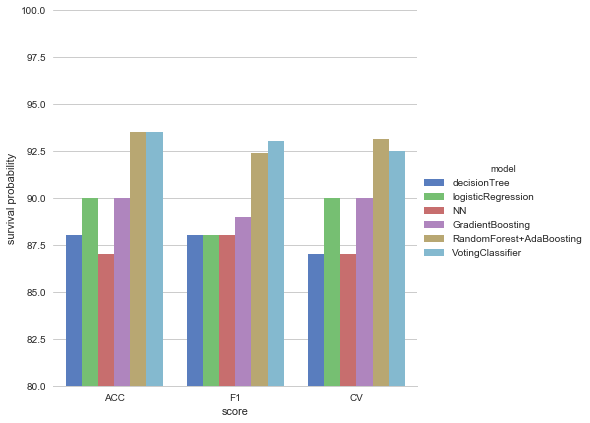

In [51]:
import seaborn as sns
sns.set(style="whitegrid")
# Draw a nested barplot to show survival for class and sex
g = sns.factorplot(x="score", y="num", hue="model", data=result2, size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("survival probability")
g.set(ylim=(80, 100))

In [49]:
y_pred_class = eclf2.predict(sfinal_test2)
print y_pred_class

[0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0
 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1
 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0
 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 1
 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0
 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0
 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1
 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1
 1 1 1 1 0 0 0 1 0 0 1 1 

### Exporting final answer as CSV

In [39]:
result = pd.DataFrame({ 'id' : test['id'], 'bot': y_pred_class })
result.to_csv('result.csv', index = False)

In [ ]:
from sklearn.metrics import make_scorer

rf_clf2 = RandomForestClassifier()

parameters = {'n_estimators': [10,20,25], 
              'max_features': [10,12,16], 
              'criterion': ['entropy', 'gini'],
              'max_depth': [6, 8, 10,12], 
              'min_samples_split': [20, 30, 50],
              'min_samples_leaf': [3,5,8]
             }

acc_scorer = make_scorer(accuracy_score)

#grid search
grid_obj = GridSearchCV(rf_clf2, parameters, scoring=acc_scorer, n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_clf2 = grid_obj.best_estimator_

rf_clf2.fit(X_train, y_train)



RandomForestClassifier(criterion='entropy', max_depth=8, max_features=10,
                       min_samples_leaf=8, min_samples_split=30,
                       n_estimators=10)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada2 = AdaBoostClassifier(base_estimator=rf_clf2, n_estimators=50)
ada2.fit(X_train, y_train)

/Users/emirkantul/Documents/Repos/bot-and-political-tweet-detection/.venv/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                         max_depth=8,
                                                         max_features=10,
                                                         min_samples_leaf=8,
                                                         min_samples_split=30,
                                                         n_estimators=10))

In [ ]:
preds = ada2.predict(X_valid)

acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

best_bot_model = ada2

MSE: 0.23833333333333334 
 Accuracy Score: 0.7883333333333333 
 Confusion Matrix: 
 [[443  50]
 [ 77  30]]
